# IMPORTS

In [1]:
# data visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# confere data.
import sklearn.metrics
import cv2
import natsort

# logger.
import pickle
import mlflow

In [2]:
# tensor calculus backend.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# neural networks abstractions.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, \
                                    Flatten, \
                                    Dense, \
                                    Dropout, \
                                    AveragePooling2D

# monitoring metrics and callbacks.
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

2023-08-07 20:12:36.118366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:12:36.172966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 20:12:36.174228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 20:12:37.159049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dev parameters

In [3]:
import sys
sys.path.insert(1, '../')

# get parameters.
from dev_modules.vcs_params import params_dataset
from dev_modules.vcs_params import params_train
from dev_modules.vcs_params import params_model

# import custom model.
from dev_modules.vcs_model import model_class

# LOGGER

In [4]:
mlflow.tensorflow.autolog()
mlflow.start_run(run_name=params_train.RUN_NAME)

mlflow.log_artifact("../dev_modules/")
mlflow.log_params(params_model.TRAIN_HYPER)

In [5]:
tf.keras.utils.set_random_seed(params_train.RANDOM_SEED)

# TRAINING GEN

In [6]:
dir_train = os.path.join("..",
                         params_dataset.DATASET_ROOT_DIR,
                         params_dataset.DATASET_TYPE,
                         params_dataset.TRAIN_DIR)

# training
train_gen = ImageDataGenerator(**params_train.TRAINING_GEN_PARAMS)

print('Training set: ')
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **params_train.TRAINING_FLOW_PARAMS)
print(train_set.class_indices)

train_files = train_set._filepaths
train_files = natsort.natsorted(train_files)

print('\nValidation set: ')
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **params_train.TRAINING_FLOW_PARAMS)
print(valid_set.class_indices)

valid_files = valid_set._filepaths
valid_files = natsort.natsorted(valid_files)

Training set: 
Found 892 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}

Validation set: 
Found 222 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}


In [7]:
train_outputs_dir = os.path.join('.', params_train.TRAIN_OUTPUTS_DIR)
TRAIN_FILES = os.path.join(train_outputs_dir, params_train.TRAIN_FILES)
VAL_FILES = os.path.join(train_outputs_dir, params_train.VAL_FILES)
os.makedirs(train_outputs_dir)

for sets_files in zip([TRAIN_FILES, VAL_FILES], [train_files, valid_files]):
    with open(sets_files[0], 'wb') as file:
        pickle.dump(sets_files[1], file)

# BUILD MODEL

In [8]:
model_obj = model_class.minimal_CNN_MCU()
model = model_obj.get_model()

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(params_train.LEARNING_RATE),
    loss=keras.losses.binary_crossentropy,
    
    metrics=[# critical for success.
             keras.metrics.Recall(),
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(),
             # auxiliar.
             keras.metrics.FalseNegatives(),
             keras.metrics.FalsePositives()],
)

model.build((1, *params_dataset.IMAGE_SIZE))
model.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 2)       20        
                                                                 
 average_pooling2d (Average  (None, 64, 64, 2)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 4)         76        
                                                                 
 average_pooling2d_1 (Avera  (None, 32, 32, 4)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 average_pooling2d_2 (Avera  (None, 16, 16, 8)         0

# TRAINING LOOP

In [10]:
epochs = params_train.NUM_EPOCHS

checkpoint_dir = os.path.join('.', params_train.MODELS_DIR)
os.makedirs(checkpoint_dir, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir,
                                                 "last")
                                    + params_train.MODEL_EXTENSION),
    
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir,
                                                 "best")
                                    + params_train.MODEL_EXTENSION,
                                    **params_train.SAVE_BEST_PARAMS),
    
    keras.callbacks.TensorBoard(log_dir=params_train.TENSORFLOW_DIR),
]

In [11]:
history = model.fit(train_set,
                    validation_data=valid_set,
                    callbacks=callbacks,
                    **params_train.FIT_PARAMS)

2023/08/07 20:12:39 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/08/07 20:12:39 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
56/56 [==============================] - 8s 81ms/step - loss: 0.6472 - recall: 0.9328 - binary_accuracy: 0.6143 - precision: 0.6188 - false_negatives: 36.0000 - false_positives: 308.0000 - val_loss: 0.6117 - val_recall: 0.8284 - val_binary_accuracy: 0.7072 - val_precision: 0.7255 - val_false_negatives: 23.0000 - val_false_positives: 42.0000


/home/vuser/Documents/backup_07302023/3_tcc_code/ML_IoT_pipeline/ML_IoT_pipeline/env_ML_pipeline/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
56/56 [==============================] - 5s 89ms/step - loss: 0.5791 - recall: 0.8004 - binary_accuracy: 0.6973 - precision: 0.7247 - false_negatives: 107.0000 - false_positives: 163.0000 - val_loss: 0.5910 - val_recall: 0.8209 - val_binary_accuracy: 0.6847 - val_precision: 0.7051 - val_false_negatives: 24.0000 - val_false_positives: 46.0000
Epoch 3/50
56/56 [==============================] - 4s 76ms/step - loss: 0.5537 - recall: 0.8097 - binary_accuracy: 0.7298 - precision: 0.7574 - false_negatives: 102.0000 - false_positives: 139.0000 - val_loss: 0.5662 - val_recall: 0.7761 - val_binary_accuracy: 0.7027 - val_precision: 0.7429 - val_false_negatives: 30.0000 - val_false_positives: 36.0000
Epoch 4/50
56/56 [==============================] - 5s 91ms/step - loss: 0.5334 - recall: 0.8041 - binary_accuracy: 0.7478 - precision: 0.7822 - false_negatives: 105.0000 - false_positives: 120.0000 - val_loss: 0.5492 - val_recall: 0.7463 - val_binary_accuracy: 0.7387 - val_precision: 0.80

2023/08/07 20:17:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/08/07 20:17:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpap3ii5dd/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpap3ii5dd/model/data/model/assets


# LOG HISTORY

In [12]:
HISTORY_FILE = os.path.join(train_outputs_dir, params_train.HISTORY_FILE)

with open(HISTORY_FILE, 'wb') as file:
    pickle.dump(history.history, file)

In [13]:
with open(HISTORY_FILE, 'rb') as file:
    history_loaded = pickle.load(file)

In [14]:
history_df = pd.DataFrame(history_loaded)
history_df

,loss,recall,binary_accuracy,precision,false_negatives,false_positives,val_loss,val_recall,val_binary_accuracy,val_precision,val_false_negatives,val_false_positives
0,0.647231,0.932836,0.614350,0.618812,36.0,308.0,0.611664,0.828358,0.707207,0.725490,23.0,42.0
1,0.579114,0.800373,0.697309,0.724662,107.0,163.0,0.591018,0.820895,0.684685,0.705128,24.0,46.0
2,0.553736,0.809702,0.729821,0.757417,102.0,139.0,0.566208,0.776119,0.702703,0.742857,30.0,36.0
3,0.533360,0.804105,0.747758,0.782214,105.0,120.0,0.549247,0.746269,0.738739,0.806452,34.0,24.0
4,0.539048,0.796642,0.726457,0.759786,109.0,135.0,0.575640,0.634328,0.707207,0.841584,49.0,16.0
5,0.492983,0.787313,0.770179,0.822612,114.0,91.0,0.484601,0.820895,0.779279,0.814815,24.0,25.0
6,0.467006,0.822761,0.772422,0.803279,95.0,108.0,0.484019,0.708955,0.765766,0.879630,39.0,13.0
7,0.426082,0.830224,0.800448,0.836466,91.0,87.0,0.442052,0.805970,0.801802,0.857143,26.0,18.0
8,0.427104,0.835821,0.789238,0.817518,88.0,100.0,0.397076,0.828358,0.792793,0.828358,23.0,23.0
9,0.395721,0.854478,0.817265,0.843462,78.0,85.0,0.412310,0.768657,0.779279,0.851240,31.0,18.0


# CONFERE MODEL LOADED

In [15]:
loaded_model = tf.keras.models.load_model(
    os.path.join(checkpoint_dir, "best.h5"))

In [16]:
loaded_model.evaluate(train_set)

56/56 [==============================] - 2s 26ms/step - loss: 0.0845 - recall: 0.9851 - binary_accuracy: 0.9776 - precision: 0.9778 - false_negatives: 8.0000 - false_positives: 12.0000


[0.08450781553983688,
 0.9850746393203735,
 0.9775784611701965,
 0.9777777791023254,
 8.0,
 12.0]

In [17]:
y_pred_valid = loaded_model.evaluate(valid_set)

14/14 [==============================] - 0s 29ms/step - loss: 0.1117 - recall: 0.9776 - binary_accuracy: 0.9640 - precision: 0.9632 - false_negatives: 3.0000 - false_positives: 5.0000


# CONFUSION MATRIX

In [18]:
def draw_confusion_matrix(y_true: np.ndarray,
                          y_pred: np.ndarray,
                          title: str) -> np.ndarray:
    """
    Plot the confusion matrix.
    Return the confusion matrix (skleanr standard).
    """
    # calculate confusion.
    confusion_matrix = sklearn.metrics.confusion_matrix(
        y_true=y_true,
        y_pred=(y_pred >= model_class.THRESHOLD_DECISION).reshape(-1,))
    
    # plot confusion matrix
    ax = sns.heatmap(confusion_matrix,
                     annot=True,
                     annot_kws={'size':14, 'weight':'bold'},
                     fmt='d', cbar=False, cmap='Blues')

    CLASSES_LIST = ['Usable', 'Defective']
    plt.title(title, size=25, weight='bold')

    plt.xlabel('Predicted', size=14, weight='bold')
    ax.set_xticklabels(CLASSES_LIST)

    plt.ylabel('Ground truth', size=14, weight='bold')
    ax.set_yticklabels(CLASSES_LIST, va='center')
    plt.tick_params(axis='both', labelsize=14, length=0)
    plt.show()
    
    return confusion_matrix
    

## Training

In [19]:
y_train_true = train_set.classes[train_set.index_array]
y_train_pred = loaded_model.predict(train_set)

56/56 [==============================] - 2s 27ms/step


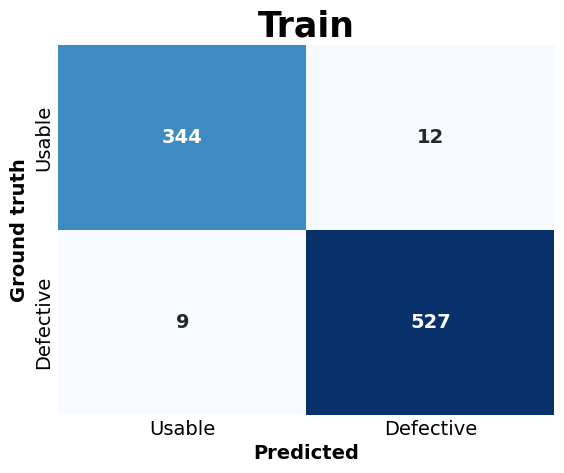

[[344  12]
 [  9 527]]


In [20]:
train_confusion_matrix = draw_confusion_matrix(
    y_true=y_train_true,
    y_pred=y_train_pred,
    title="Train")
print(train_confusion_matrix)

In [21]:
CONFUSION_TRAIN_FILE = os.path.join(train_outputs_dir, params_train.CONFUSION_TRAIN_FILE)
with open(CONFUSION_TRAIN_FILE, 'wb') as file:
    pickle.dump(train_confusion_matrix, file)

## Validation

In [22]:
y_val_true = valid_set.classes[valid_set.index_array]
y_val_pred = loaded_model.predict(valid_set)

14/14 [==============================] - 0s 26ms/step


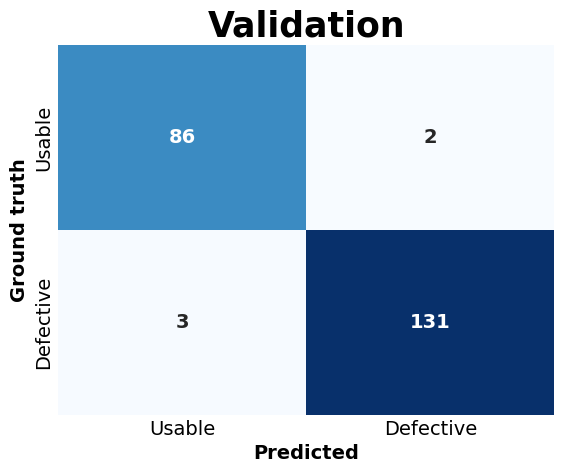

[[ 86   2]
 [  3 131]]


In [23]:
val_confusion_matrix = draw_confusion_matrix(
    y_true=y_val_true,
    y_pred=y_val_pred,
    title="Validation")
print(val_confusion_matrix)

In [24]:
CONFUSION_VAL_FILE = os.path.join(train_outputs_dir, params_train.CONFUSION_VAL_FILE)
with open(CONFUSION_VAL_FILE, 'wb') as file:
    pickle.dump(val_confusion_matrix, file)

# VISUALIZE ERRORS

In [25]:
def visualize_errors(files_set: list,
                     save_dir: str,
                     number_to_plot: int = 5) -> None:
    """
    Visualize and save predicted errors.
    Return files that the model infered wrong.
    """
    os.makedirs(save_dir, exist_ok=True)
    wrong_inference = list()
    
    FP_count = 0
    FN_count = 0
    for file in files_set:
        ground_truth = int(file.split('/')[-2][0])
        filename = file.split("/")[-1]

        sample = keras.preprocessing.image.load_img(file, grayscale=True)
        sample = keras.preprocessing.image.img_to_array(sample)
        sample = np.expand_dims(sample, 0)
        pred = loaded_model.predict(sample)
        pred = (pred >= model_class.THRESHOLD_DECISION).reshape(-1,)
        
        diff = pred - ground_truth
        # 0 : ok
        # 1 : pred==1, gt==0 -> FP
        # -1: pred==0, gt==1 -> FN

        if diff:
            wrong_inference.append(filename)
            if diff == 1:
                FP_count += 1
                title = "FP"
                count = FP_count
            else:
                FN_count += 1
                title = "FN"
                count = FN_count
                
            image = sample[0, :, :, 0]
            cv2.imwrite(os.path.join(save_dir, filename), image)
            
            if count <= number_to_plot:
                plt.figure(figsize=(3, 3))
                plt.imshow(image, cmap="gray")
                plt.title(title)
                
    plt.show()
    
    wrong_inference = natsort.natsorted(wrong_inference)
    return wrong_inference

/home/vuser/Documents/backup_07302023/3_tcc_code/ML_IoT_pipeline/ML_IoT_pipeline/env_ML_pipeline/lib/python3.9/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 27ms/step


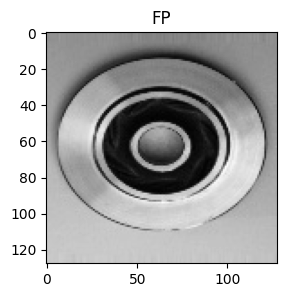

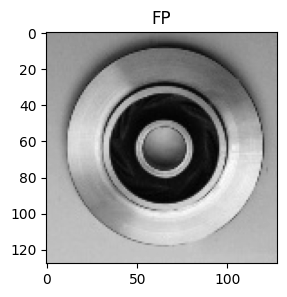

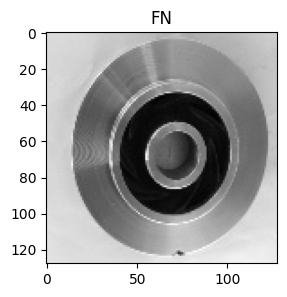

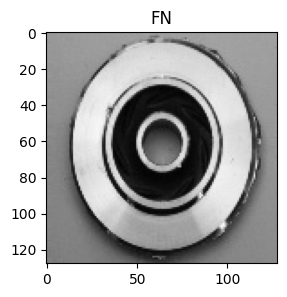

In [26]:
val_errors_dir = os.path.join(train_outputs_dir, params_train.VAL_ERRORS_DIR)

wrong_in_val = visualize_errors(valid_files, val_errors_dir, 2)

1/1 [==============================] - 0s 20ms/step


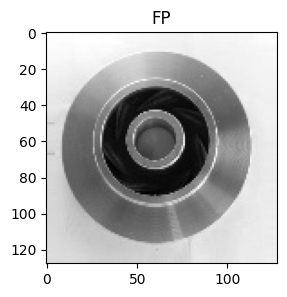

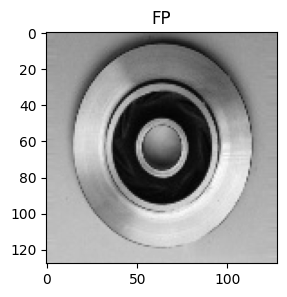

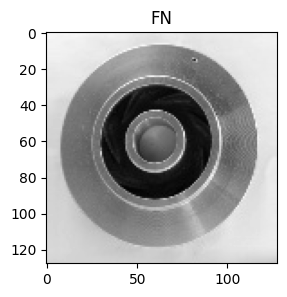

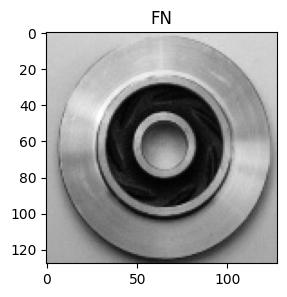

In [27]:
train_errors_dir = os.path.join(train_outputs_dir, params_train.TRAIN_ERRORS_DIR)

wrong_in_train = visualize_errors(train_files, train_errors_dir, 2)

In [28]:
WRONG_TRAIN_FILE = os.path.join(train_outputs_dir, params_train.WRONG_TRAIN_FILE)
WRONG_VAL_FILE = os.path.join(train_outputs_dir, params_train.WRONG_VAL_FILE)

for wrong_files in zip([WRONG_TRAIN_FILE, WRONG_VAL_FILE], [wrong_in_train, wrong_in_val]):
    with open(wrong_files[0], 'wb') as file:
        pickle.dump(wrong_files[1], file)

# FINISH LOG

In [29]:
mlflow.log_artifact(train_outputs_dir)

In [30]:
mlflow.end_run()